In [8]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import DataLoader
from torch import nn, optim

from src.dataset import SpeechDataset
from src.cnn_lstm import CNNLSTM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU utilisé : ",torch.cuda.get_device_name(0))


GPU utilisé :  NVIDIA GeForce RTX 4050 Laptop GPU


In [9]:
dataset = SpeechDataset("../data/processed/mfcc", feature_type="mfcc")
len(dataset)


44652

Padding car sample 1 : [101,40] & sample 2 = [61,40]

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    xs, ys = zip(*batch)

    # padding sur la dimension temporelle (T diffère)
    xs = [torch.tensor(x, dtype=torch.float32) for x in xs]
    xs = pad_sequence(xs, batch_first=True)   # -> (batch, max_T, 40)

    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys


In [11]:
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_batch
)


model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model


CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [13]:
epochs = 20
loss_history = []

for epoch in range(epochs):
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    loss_history.append(total)
    print(f"Epoch : {epoch+1} | Loss : {total}")


/tmp/ipykernel_2029/1344744160.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs = [torch.tensor(x, dtype=torch.float32) for x in xs]


Epoch : 1 | Loss : 2101.0370312929153
Epoch : 2 | Loss : 2054.6574662923813
Epoch : 3 | Loss : 2028.3847044706345
Epoch : 4 | Loss : 2010.609266757965
Epoch : 5 | Loss : 1992.2213752269745
Epoch : 6 | Loss : 1963.196969985962
Epoch : 7 | Loss : 1938.5512037873268
Epoch : 8 | Loss : 1898.3678782582283
Epoch : 9 | Loss : 1858.8103970885277
Epoch : 10 | Loss : 1803.9631741642952
Epoch : 11 | Loss : 1758.8793222904205
Epoch : 12 | Loss : 1716.8364515900612
Epoch : 13 | Loss : 1676.8394802808762
Epoch : 14 | Loss : 1641.8011319637299
Epoch : 15 | Loss : 1614.553833425045
Epoch : 16 | Loss : 1583.3520938158035
Epoch : 17 | Loss : 1546.5612875819206
Epoch : 18 | Loss : 1521.3535346388817
Epoch : 19 | Loss : 1496.4838562607765
Epoch : 20 | Loss : 1463.0006873607635


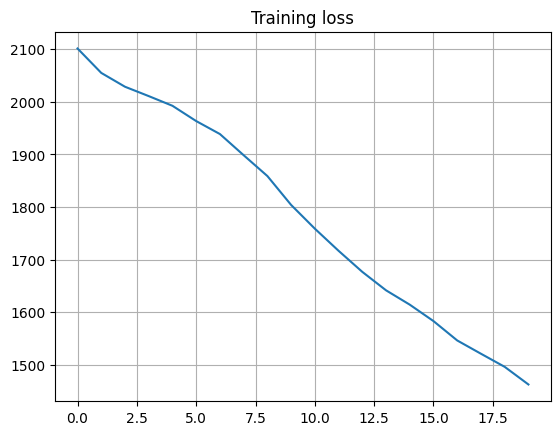

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training loss")
plt.grid()
plt.show()


In [15]:
torch.save(model.state_dict(), "models/cnn_lstm.pth")


Notes sur le CNN + LSTM

- Le modèle apprend mais plus lentement que le CNN 2D.
- Les MFCC contiennent moins d’informations que les MelSpectrograms, ce qui limite les performances.
- Le padding ajouté sur les séquences MFCC introduit du bruit dans l’entraînement.
- Le CNN 2D reste plus efficace pour la reconnaissance d’émotion dans notre cas.
